In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

# imports
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import scienceplots
plt.style.use(['science','no-latex'])

# change matplotlib colormap
cmap = 'magma'
plt.rcParams['image.cmap'] = cmap

# add src to path
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(''), '../..')))
from src.dynamics import dynamics
from src.linear_response import response, response_regime_metric


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:

def compute_activity(W, I_ext, nonlinearity='relu'):
    """
    Compute steady-state activity for external input.
    r_ss = phi(W @ r_ss + I_ext)
    """
    max_iter = 100
    r = np.zeros(W.shape[0])
    
    for _ in range(max_iter):
        r_new = W @ r + I_ext
        
        if nonlinearity == 'relu':
            r_new = np.maximum(r_new, 0)
        elif nonlinearity == 'tanh':
            r_new = np.tanh(r_new)
        elif nonlinearity == 'sigmoid':
            r_new = 1 / (1 + np.exp(-r_new))
        
        if np.allclose(r, r_new, atol=1e-6):
            break
        r = r_new
    
    return r

In [4]:

class PlasticNetwork:
    """
    Network with long-term plasticity that accumulates over learning episodes.
    """
    
    def __init__(self, J, alpha, beta, g, delta, plasticity_rule='hebbian',
                 eta=0.01, alpha_plastic=True, beta_plastic=True):
        """
        Initialize network with structural parameters.
        
        Parameters:
        - alpha_plastic: whether alpha can change with plasticity
        - beta_plastic: whether beta can change with plasticity
        """
        self.J = J
        self.alpha_base = alpha
        self.beta_base = beta
        self.g = g
        self.delta = delta
        self.eta = eta
        self.plasticity_rule = plasticity_rule
        self.alpha_plastic = alpha_plastic
        self.beta_plastic = beta_plastic
        
        # Initialize weights
        self.W = np.array([[J, beta*J, -delta*J],
                          [alpha*J, J, -delta*J],
                          [J, J, -g*J]])
        
        # Track alpha and beta over time
        self.alpha_history = [alpha]
        self.beta_history = [beta]
        self.W_history = [self.W.copy()]
        
    def get_current_alpha_beta(self):
        """Extract current alpha and beta from weight matrix."""
        alpha = self.W[1, 0] / self.W[1, 1] if self.W[1, 1] != 0 else self.alpha_base
        beta = self.W[0, 1] / self.W[0, 0] if self.W[0, 0] != 0 else self.beta_base
        return alpha, beta
    
    def learning_episode(self, I_learning, n_timesteps=50):
        """
        Simulate one learning episode with sustained input.
        Updates weights based on activity during the episode.
        """
        # Initialize activity
        r = np.zeros(3)
        
        for t in range(n_timesteps):
            # Compute activity
            r = compute_activity(self.W, I_learning, nonlinearity='relu')
            
            # Apply plasticity rule
            if self.plasticity_rule == 'hebbian':
                # Hebbian: strengthen co-active connections
                dW = self.eta * np.outer(r, r)
                
            elif self.plasticity_rule == 'oja':
                # Oja's rule: normalized Hebbian
                dW = np.zeros_like(self.W)
                for i in range(3):
                    for j in range(3):
                        dW[i, j] = self.eta * r[i] * (r[j] - self.W[i, j] * r[i])
                        
            elif self.plasticity_rule == 'covariance':
                # Covariance rule: only strengthen if both above baseline
                r_baseline = 0.3
                r_centered = r - r_baseline
                dW = self.eta * np.outer(r_centered, r_centered)
                
            elif self.plasticity_rule == 'bcm':
                # BCM rule: activity-dependent threshold
                theta = np.mean(r**2)
                dW = np.zeros_like(self.W)
                for i in range(3):
                    for j in range(3):
                        dW[i, j] = self.eta * r[i] * r[j] * (r[j] - theta)
            
            # Update weights
            self.W = self.W + dW
            
            # Apply constraints
            self._apply_constraints()
        
        # Store history
        alpha, beta = self.get_current_alpha_beta()
        self.alpha_history.append(alpha)
        self.beta_history.append(beta)
        self.W_history.append(self.W.copy())
        
        return r
    
    def _apply_constraints(self):
        """Apply biological constraints to weights."""
        # Keep inhibitory weights negative
        self.W[0, 2] = -np.abs(self.W[0, 2])
        self.W[1, 2] = -np.abs(self.W[1, 2])
        self.W[2, 2] = -np.abs(self.W[2, 2])
        
        # Keep excitatory weights positive
        self.W[0, 0] = np.abs(self.W[0, 0])
        self.W[0, 1] = np.abs(self.W[0, 1])
        self.W[1, 0] = np.abs(self.W[1, 0])
        self.W[1, 1] = np.abs(self.W[1, 1])
        self.W[2, 0] = np.abs(self.W[2, 0])
        self.W[2, 1] = np.abs(self.W[2, 1])
        
        # Optionally preserve alpha/beta structure
        if not self.alpha_plastic:
            self.W[1, 0] = self.alpha_base * self.W[1, 1]
        if not self.beta_plastic:
            self.W[0, 1] = self.beta_base * self.W[0, 0]
    
    def compute_response(self, I_test):
        """Compute linear response with current weights."""
        return response(self.W, I_test)

In [5]:

def simulate_learning_trajectory(J, alpha_init, beta_init, g, delta,
                                 I_learning, n_episodes=100,
                                 plasticity_rule='hebbian', eta=0.01,
                                 alpha_plastic=True, beta_plastic=True):
    """
    Simulate learning over multiple episodes and track how alpha/beta evolve.
    """
    net = PlasticNetwork(J, alpha_init, beta_init, g, delta,
                        plasticity_rule=plasticity_rule, eta=eta,
                        alpha_plastic=alpha_plastic, beta_plastic=beta_plastic)
    
    for episode in range(n_episodes):
        net.learning_episode(I_learning)
    
    return net


def plot_learning_trajectory(net, I_test, save_fig_location='../results/long_term_plastic/'):
    """
    Plot how the network evolves in (alpha, beta) space over learning.
    """
    fig, axes = plt.subplots(1, 3, figsize=(14, 4), dpi=250)
    
    # Plot 1: Trajectory in (alpha, beta) space
    alphas = np.array(net.alpha_history)
    betas = np.array(net.beta_history)
    
    axes[0].plot(betas, alphas, 'o-', alpha=0.6, markersize=3, linewidth=1)
    axes[0].plot(betas[0], alphas[0], 'go', markersize=10, label='Initial')
    axes[0].plot(betas[-1], alphas[-1], 'r*', markersize=15, label='Final')
    axes[0].set_xlabel(r'$\beta$', fontsize=14)
    axes[0].set_ylabel(r'$\alpha$', fontsize=14)
    axes[0].set_title('Learning Trajectory', fontsize=14)
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Plot 2: Alpha and beta over time
    episodes = np.arange(len(alphas))
    axes[1].plot(episodes, alphas, 'b-', label=r'$\alpha$', linewidth=2)
    axes[1].plot(episodes, betas, 'r-', label=r'$\beta$', linewidth=2)
    axes[1].set_xlabel('Episode', fontsize=14)
    axes[1].set_ylabel('Parameter Value', fontsize=14)
    axes[1].set_title('Parameter Evolution', fontsize=14)
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    # Plot 3: Response evolution
    R_l_history = []
    R_e_history = []
    for W in net.W_history:
        try:
            R_l, R_e = response(W, I_test)
            R_l_history.append(R_l)
            R_e_history.append(R_e)
        except:
            R_l_history.append(np.nan)
            R_e_history.append(np.nan)
    
    axes[2].plot(episodes, R_l_history, 'b-', label=r'$R_L$', linewidth=2)
    axes[2].plot(episodes, R_e_history, 'r-', label=r'$R_E$', linewidth=2)
    axes[2].axhline(0, color='k', linestyle='--', alpha=0.5)
    axes[2].set_xlabel('Episode', fontsize=14)
    axes[2].set_ylabel('Response', fontsize=14)
    axes[2].set_title('Response Evolution', fontsize=14)
    axes[2].legend()
    axes[2].grid(alpha=0.3)
    
    fig.tight_layout()
    if not os.path.exists(save_fig_location):
        os.makedirs(save_fig_location)
    fig.savefig(os.path.join(save_fig_location, f'learning_trajectory_{net.plasticity_rule}.png'), dpi=500)
    plt.show()


def plot_regime_map_with_trajectories(J, g, delta, I_learning, I_test,
                                       n_episodes=50, plasticity_rule='hebbian',
                                       eta=0.01, density=50, n_trajectories=5,
                                       save_fig_location='../results/long_term_plastic/'):
    """
    Plot response regime map with multiple learning trajectories overlaid.
    """
    # Compute regime map
    alpha_arr = np.linspace(0.1, 2, density)
    beta_arr = np.linspace(0.1, 2, density)
    
    R_l = np.zeros((len(alpha_arr), len(beta_arr)))
    R_e = np.zeros((len(alpha_arr), len(beta_arr)))
    
    for alpha_idx, alpha in enumerate(alpha_arr):
        for beta_idx, beta in enumerate(beta_arr):
            W = np.array([[J, beta*J, -delta*J],
                         [alpha*J, J, -delta*J],
                         [J, J, -g*J]])
            try:
                R_l[alpha_idx, beta_idx], R_e[alpha_idx, beta_idx] = response(W, I_test)
            except:
                R_l[alpha_idx, beta_idx] = np.nan
                R_e[alpha_idx, beta_idx] = np.nan
    
    R_eff = response_regime_metric(R_l, R_e)
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=250)
    
    # Plot regime map
    im = ax.imshow(R_eff, extent=(0.1, 2, 0.1, 2), origin='lower', 
                   aspect='auto', alpha=0.7, cmap='tab10')
    
    # Simulate multiple trajectories
    colors = plt.cm.rainbow(np.linspace(0, 1, n_trajectories))
    
    for i in range(n_trajectories):
        alpha_init = np.random.uniform(0.2, 1.8)
        beta_init = np.random.uniform(0.2, 1.8)
        
        net = simulate_learning_trajectory(J, alpha_init, beta_init, g, delta,
                                          I_learning, n_episodes=n_episodes,
                                          plasticity_rule=plasticity_rule, eta=eta,
                                          alpha_plastic=True, beta_plastic=True)
        
        alphas = np.array(net.alpha_history)
        betas = np.array(net.beta_history)
        
        ax.plot(betas, alphas, 'o-', color=colors[i], alpha=0.8, 
                markersize=2, linewidth=1.5, label=f'Traj {i+1}')
        ax.plot(betas[0], alphas[0], 'o', color=colors[i], markersize=8)
        ax.plot(betas[-1], alphas[-1], '*', color=colors[i], markersize=12)
    
    ax.set_xlabel(r'$\beta$', fontsize=16)
    ax.set_ylabel(r'$\alpha$', fontsize=16)
    ax.set_title(f'Learning Trajectories ({plasticity_rule})', fontsize=16)
    
    cbar = fig.colorbar(im, ax=ax, ticks=[0, 1, 2, 3])
    cbar.ax.set_yticklabels(['Acquisition', 'Early recall', 'Late recall', 'Both neg'])
    
    ax.legend(loc='upper right', fontsize=8)
    fig.tight_layout()
    
    if not os.path.exists(save_fig_location):
        os.makedirs(save_fig_location)
    fig.savefig(os.path.join(save_fig_location, 
                f'regime_map_with_trajectories_{plasticity_rule}.png'), dpi=500)
    plt.show()


def compare_plasticity_rules(J, alpha_init, beta_init, g, delta, 
                             I_learning, I_test, n_episodes=100,
                             save_fig_location='../results/long_term_plastic/'):
    """
    Compare how different plasticity rules affect learning trajectories.
    """
    rules = ['hebbian', 'oja', 'covariance', 'bcm']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=250)
    axes = axes.flatten()
    
    for idx, rule in enumerate(rules):
        # Simulate learning
        net = simulate_learning_trajectory(J, alpha_init, beta_init, g, delta,
                                          I_learning, n_episodes=n_episodes,
                                          plasticity_rule=rule, eta=0.01)
        
        # Plot trajectory
        alphas = np.array(net.alpha_history)
        betas = np.array(net.beta_history)
        
        axes[idx].plot(betas, alphas, 'o-', alpha=0.6, markersize=3, linewidth=1)
        axes[idx].plot(betas[0], alphas[0], 'go', markersize=10, label='Initial')
        axes[idx].plot(betas[-1], alphas[-1], 'r*', markersize=15, label='Final')
        axes[idx].set_xlabel(r'$\beta$', fontsize=12)
        axes[idx].set_ylabel(r'$\alpha$', fontsize=12)
        axes[idx].set_title(f'{rule.capitalize()} Rule', fontsize=14)
        axes[idx].legend()
        axes[idx].grid(alpha=0.3)
        axes[idx].set_xlim(0, 2)
        axes[idx].set_ylim(0, 2)
    
    fig.tight_layout()
    # if not os.path.exists(save_fig_location):
    #     os.makedirs(save_fig_location)
    # fig.savefig(os.path.join(save_fig_location, 'plasticity_rule_comparison.png'), dpi=500)
    plt.show()

Simulating single learning trajectory...


/Users/divyansh/miniforge3/envs/mean_field/lib/python3.13/site-packages/numpy/_core/numeric.py:995: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/var/folders/g6/7nyb4bzj60n8q754q7qp7z200000gn/T/ipykernel_19430/474730224.py:10: RuntimeWarning: invalid value encountered in matmul
  r_new = W @ r + I_ext
/Users/divyansh/miniforge3/envs/mean_field/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2430: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


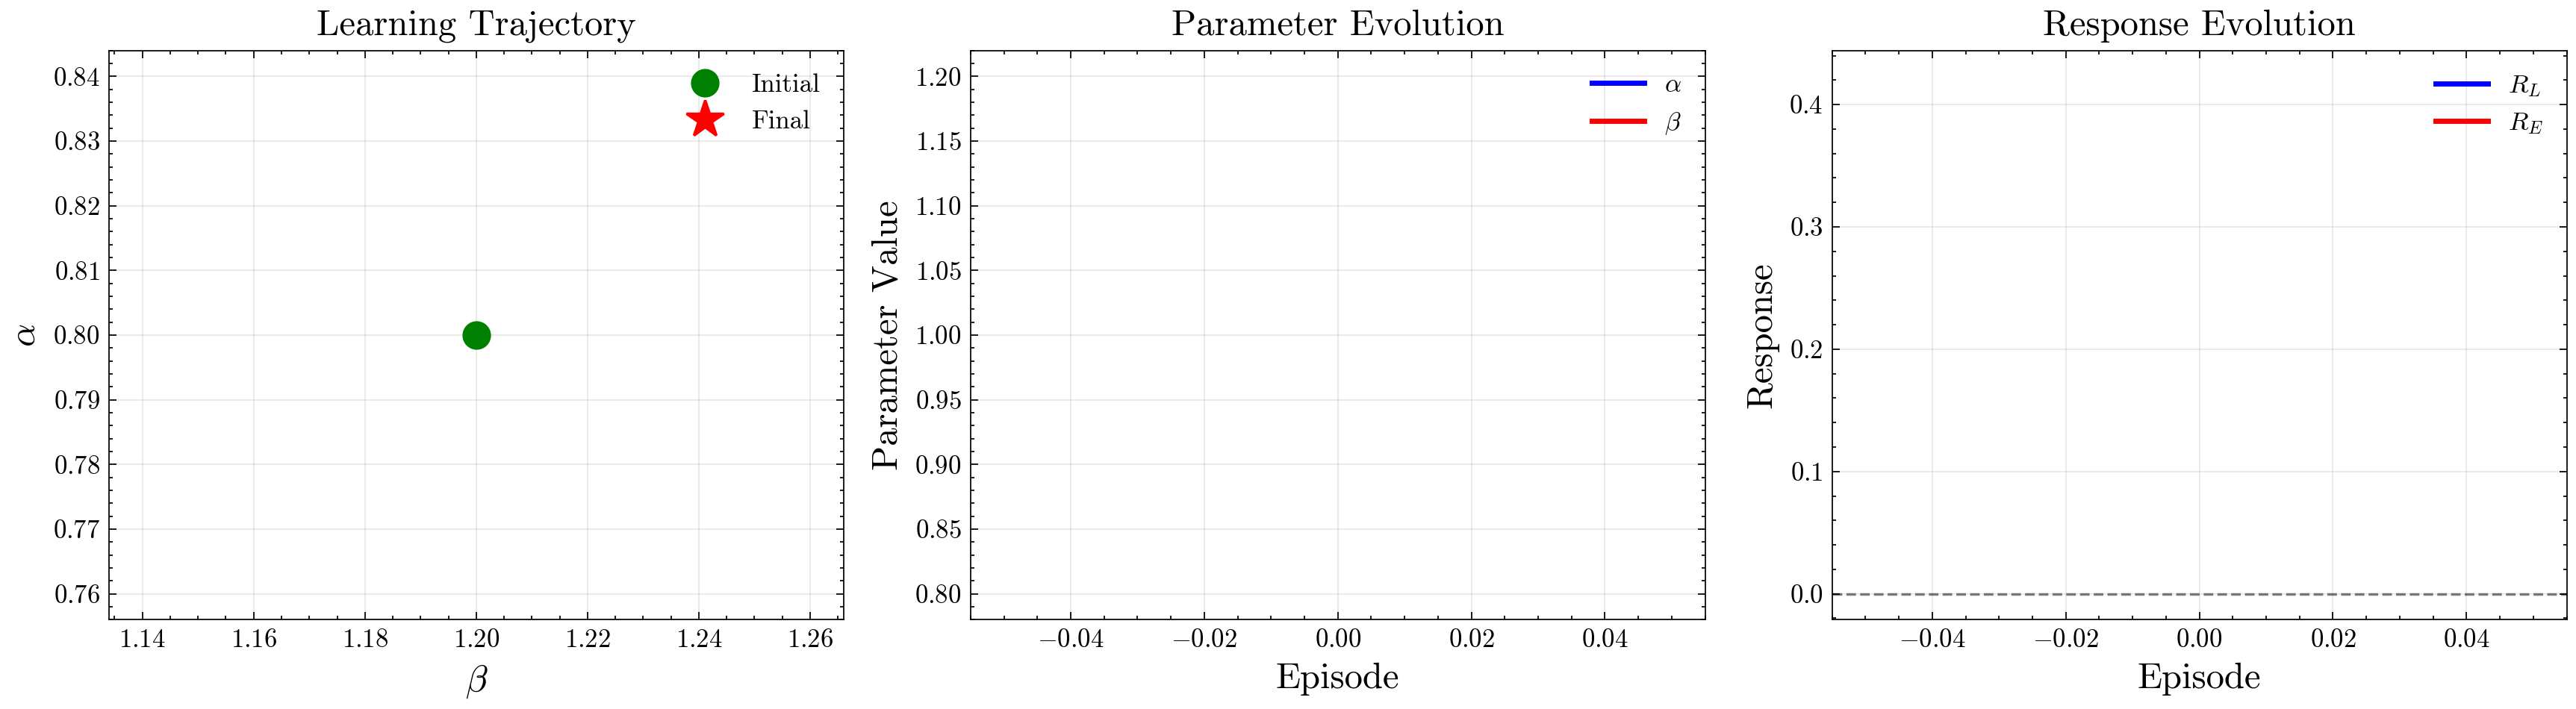


Plotting regime map with multiple trajectories...


/var/folders/g6/7nyb4bzj60n8q754q7qp7z200000gn/T/ipykernel_19430/474730224.py:10: RuntimeWarning: overflow encountered in matmul
  r_new = W @ r + I_ext


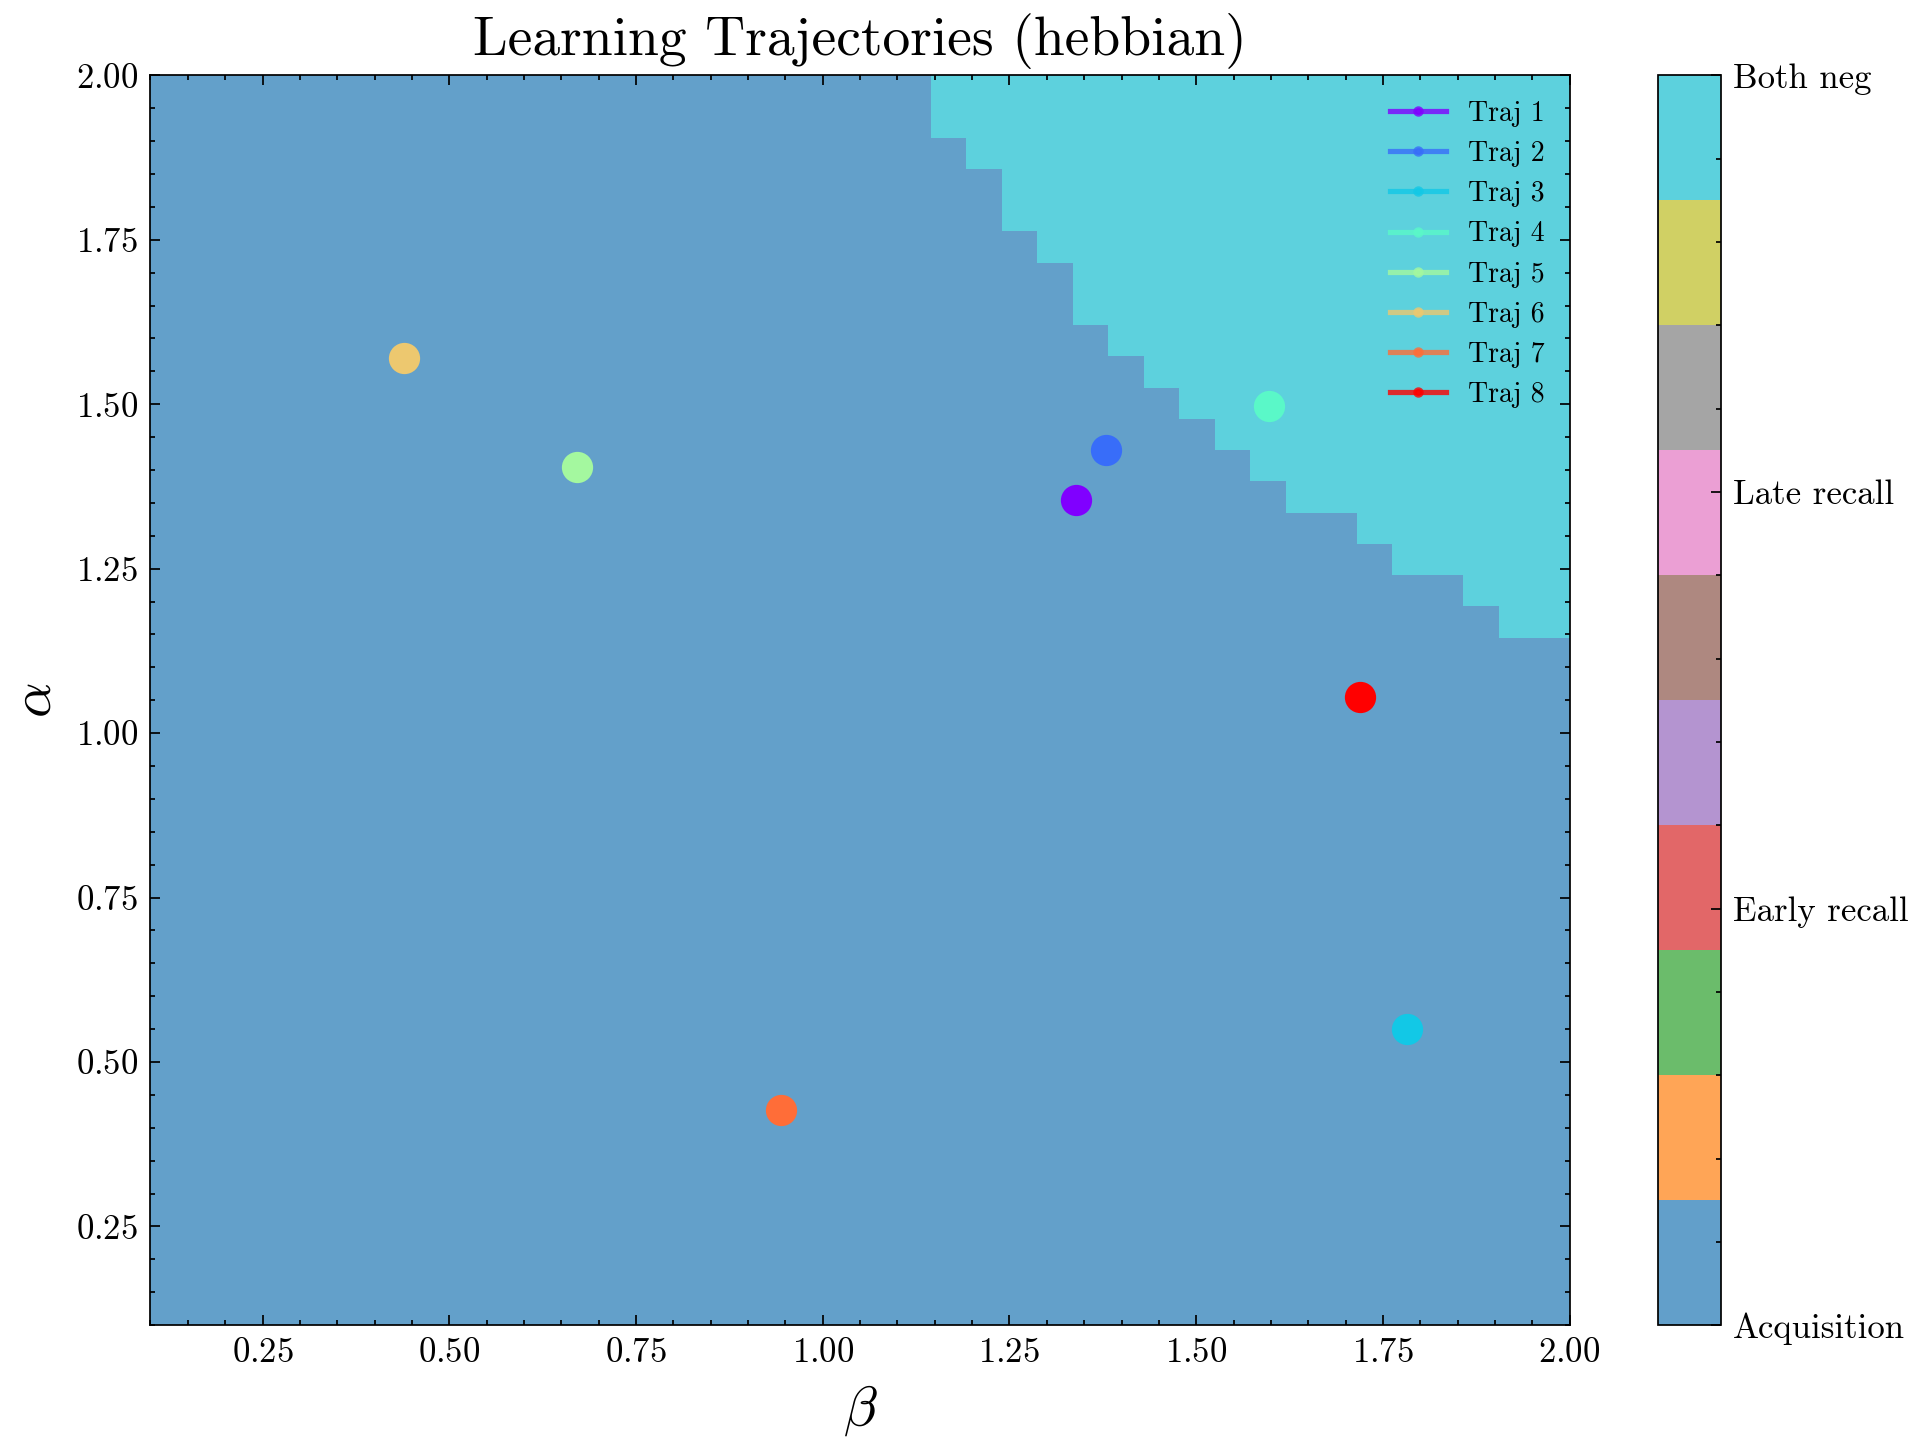


Comparing different plasticity rules...


/Users/divyansh/miniforge3/envs/mean_field/lib/python3.13/site-packages/numpy/_core/numeric.py:995: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/var/folders/g6/7nyb4bzj60n8q754q7qp7z200000gn/T/ipykernel_19430/474730224.py:10: RuntimeWarning: invalid value encountered in matmul
  r_new = W @ r + I_ext
/var/folders/g6/7nyb4bzj60n8q754q7qp7z200000gn/T/ipykernel_19430/474730224.py:10: RuntimeWarning: overflow encountered in matmul
  r_new = W @ r + I_ext


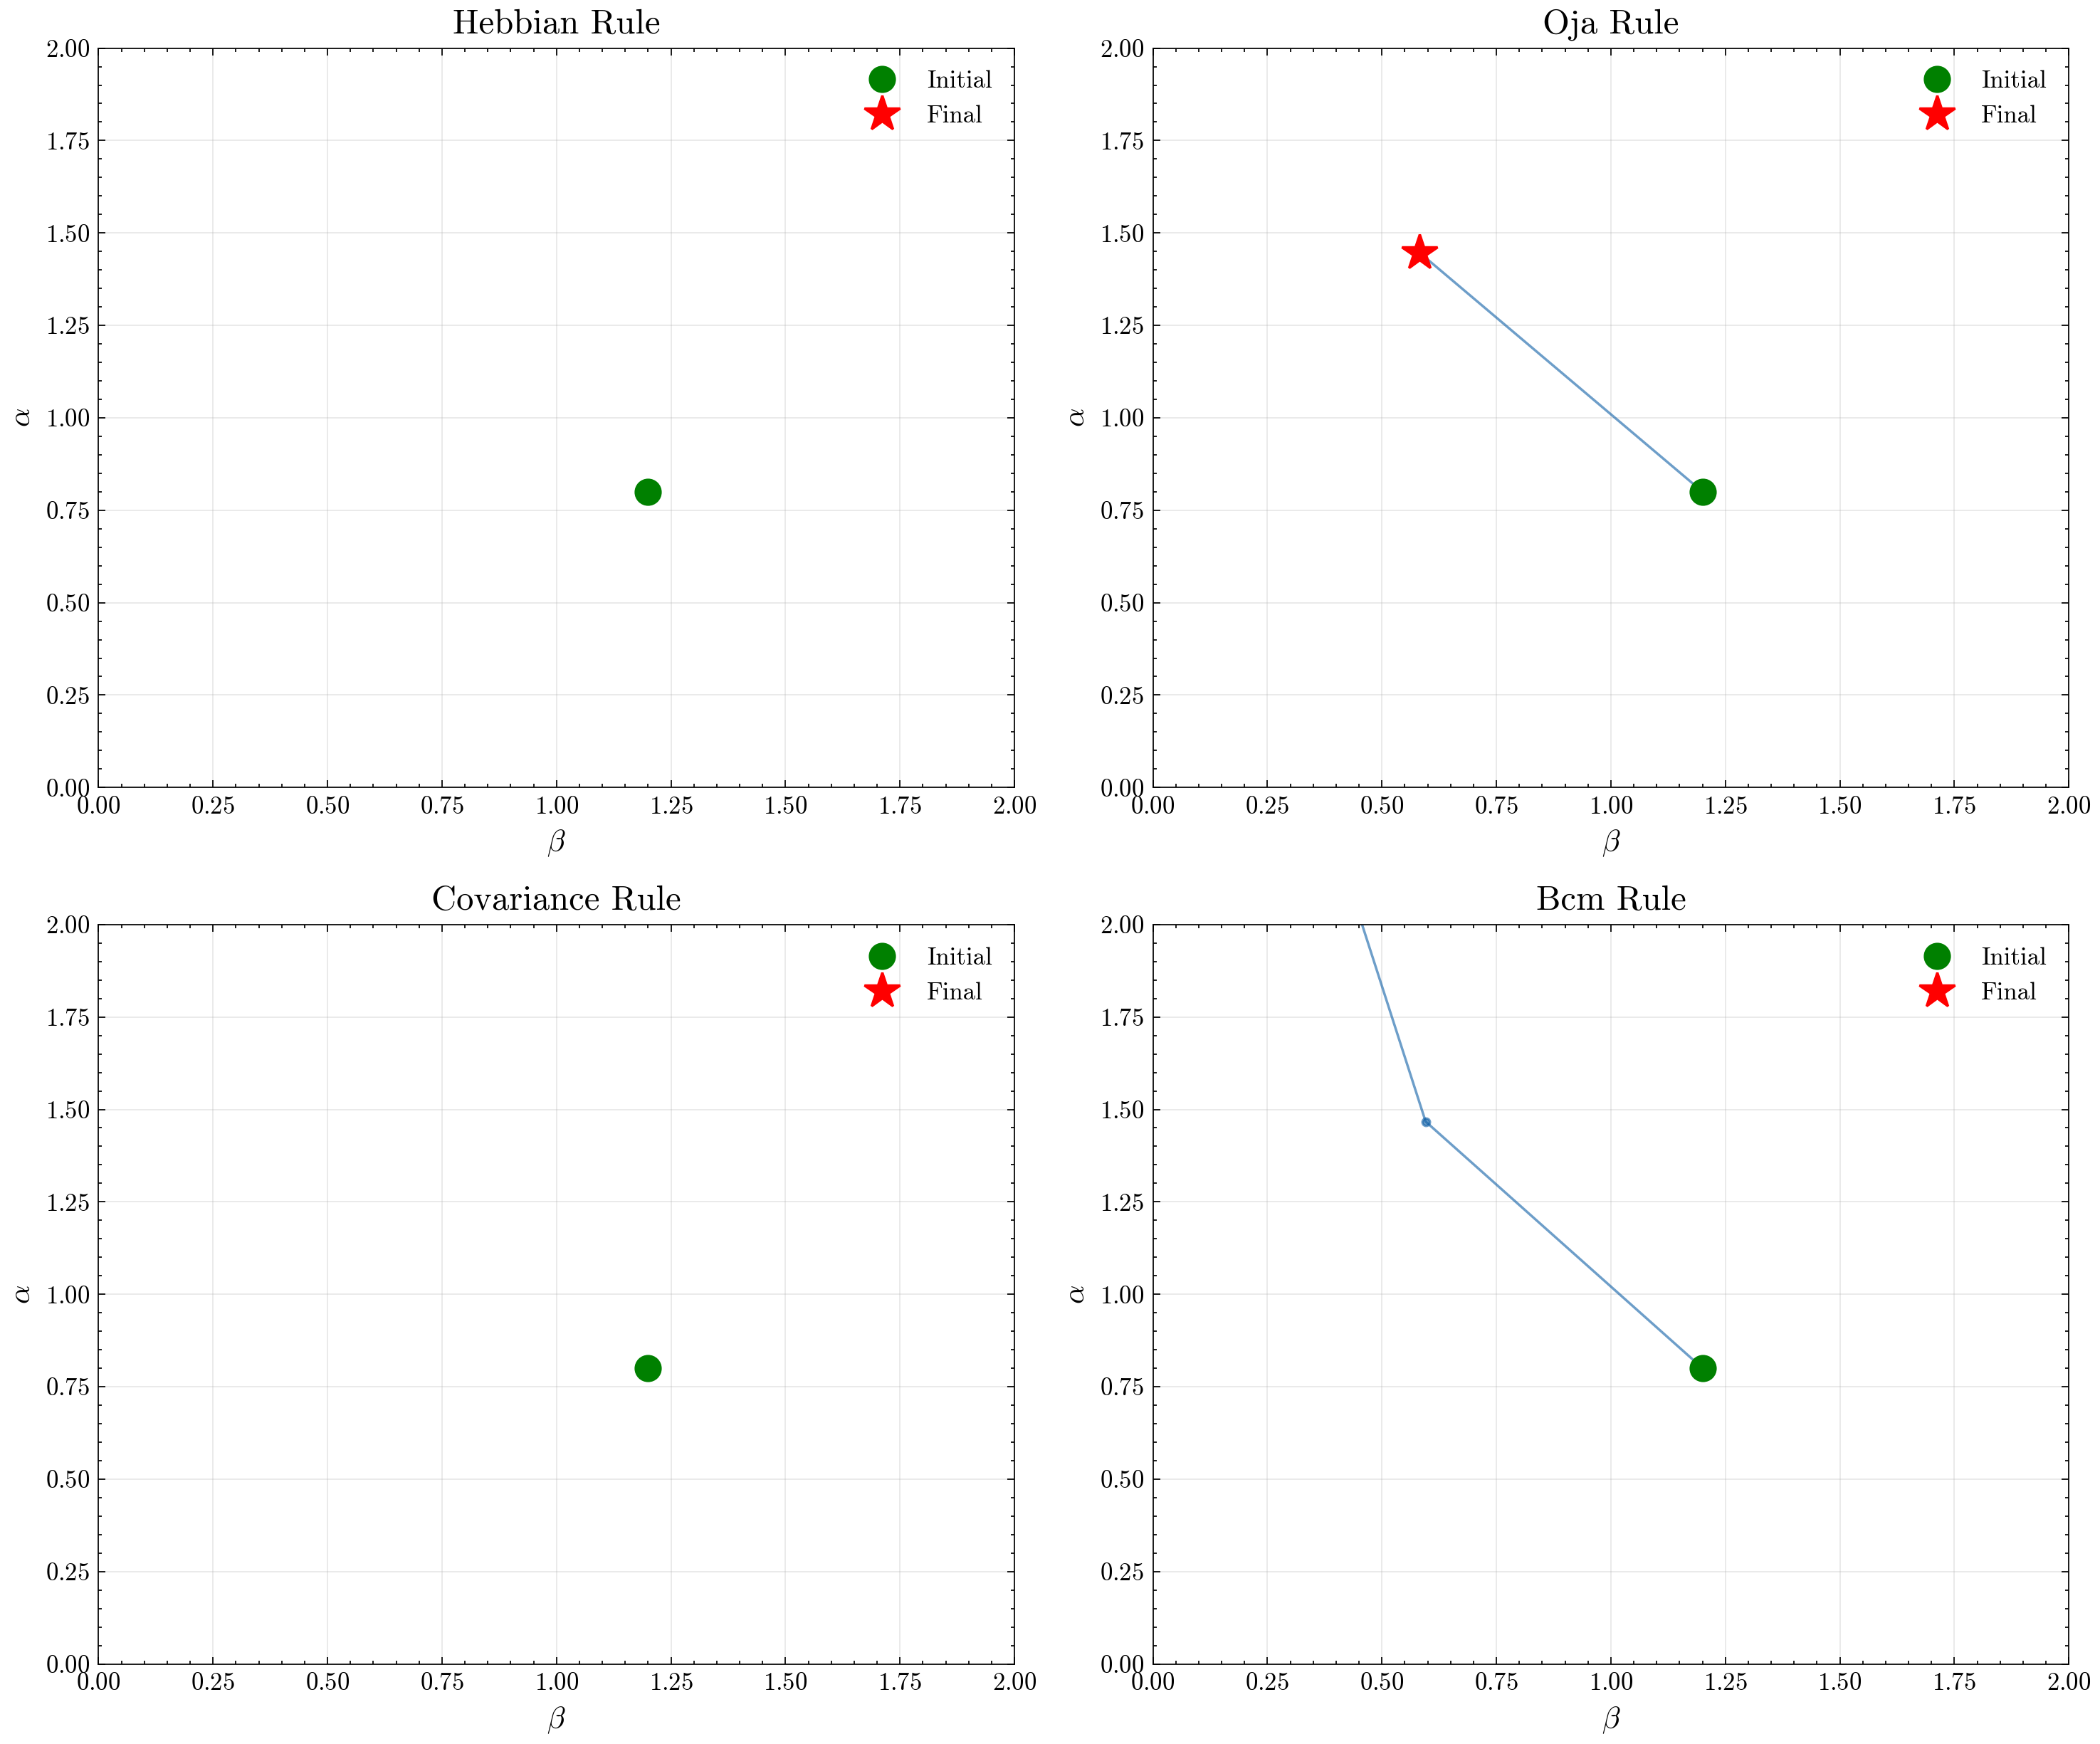

In [7]:
J = 0.5
g = 1.2
delta = 0.8

# Initial alpha and beta
alpha_init = 0.8
beta_init = 1.2

# Learning input (sustained input during learning)
I_learning = np.array([0.5, 0.3, 0.0])

# Test input (perturbation to test response)
I_test = np.array([0.1, 0.1, 0.0])

print("Simulating single learning trajectory...")
net = simulate_learning_trajectory(J, alpha_init, beta_init, g, delta,
                                    I_learning, n_episodes=100,
                                    plasticity_rule='hebbian', eta=0.01)
plot_learning_trajectory(net, I_test)

print("\nPlotting regime map with multiple trajectories...")
plot_regime_map_with_trajectories(J, g, delta, I_learning, I_test,
                                    n_episodes=50, plasticity_rule='hebbian',
                                    density=40, n_trajectories=8)

print("\nComparing different plasticity rules...")
compare_plasticity_rules(J, alpha_init, beta_init, g, delta,
                        I_learning, I_test, n_episodes=100)